In [3]:
! pip install pywph==1.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pywph as pw
import numpy as np
import torch
from sklearn.utils.extmath import svd_flip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
params = pd.read_csv('drive/MyDrive/camels data/params.csv')
nbody_file = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mgas_file = np.load('drive/MyDrive/camels data/Maps_Mgas_SIMBA_LH_z=0.00.npy')
#wph_coeffs_1000 = pd.read_csv('drive/MyDrive/camels data/wph_coeffs_1000.csv')

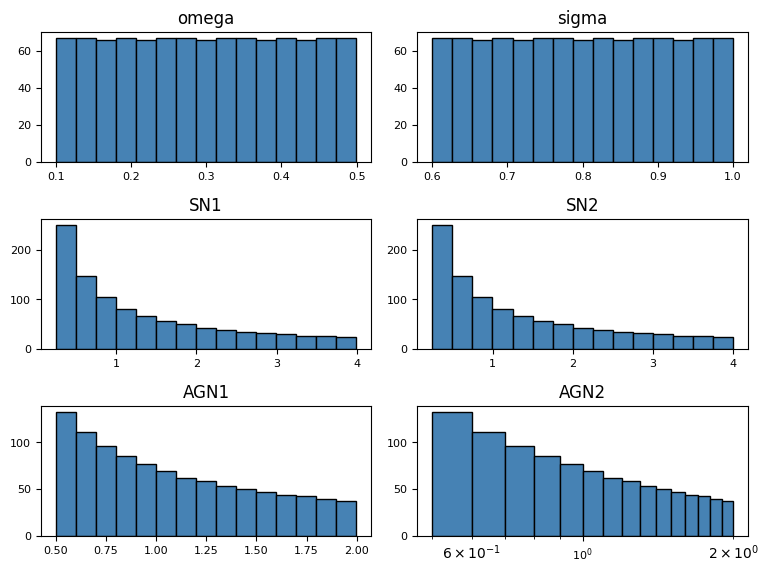

In [4]:
# parameters
params.hist(bins=15, color='steelblue',edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8,grid=False)
plt.tight_layout(rect=(0,0, 1.2, 1.2))
plt.xscale('log')

In [7]:
def PCA(data, num_components):
    """calculate the principal components"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)
    U,V = svd_flip(U,V) # flip sign to enforce deterministic output

    # project onto the new space
    data_transformed = data_standard.dot(V[:num_components].T)
    data_reduced = U[:,:num_components]*S[:num_components]

    return data_reduced

def PCA_weight(data, num_components):
    """calculate the weighting of each WPH coefficient"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)
    U,V = svd_flip(U,V) # flip sign to enforce deterministic output

    return V[:2]

def PCA_explained_variance_ratio(data, num_components):
    """calculate the explained_variance_ratio"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)

    n_data, n_features = data.shape
    explained_variance_ = (S**2)/(n_data - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio = explained_variance_/total_var

    return explained_variance_ratio[:2]

In [23]:
nbody = np.copy(nbody_file[0])
nbody_data = np.log(nbody)

mgas = np.copy(mgas_file[0])
mgas_data = np.log(mgas)

In [24]:
M = 256
N = 256
J = 7
L = 4
dn =0

wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)
wph_op.load_model(cross_moments=True)
joint_coeff = wph_op([nbody_data, mgas_data], cross=True, pbc=True)

if torch.cuda.is_available():
    wph_op.to(0)

In [25]:
# cross coeff: "S11", "S00", "C00", "S01", "C01", "S10", "C10", "Cphase", "Cphase_inv", "L"

In [26]:
wph = wph_op([nbody_data, mgas_data], cross=True, ret_wph_obj=True, norm=None)
S11_shape = (wph.get_coeffs("S11")[0].shape)[0]
S00_shape = (wph.get_coeffs("S00")[0].shape)[0]
C00_shape = (wph.get_coeffs("C00")[0].shape)[0]
S01_shape = (wph.get_coeffs("S01")[0].shape)[0]
C01_shape = (wph.get_coeffs("C01")[0].shape)[0]
S10_shape = (wph.get_coeffs("S10")[0].shape)[0]
C10_shape = (wph.get_coeffs("C10")[0].shape)[0]
Cphase_shape = (wph.get_coeffs("Cphase")[0].shape)[0]
Cphase_inv_shape = (wph.get_coeffs("Cphase_inv")[0].shape)[0]
L_shape = (wph.get_coeffs("L")[0].shape)[0]


In [54]:
num = 1000
nbody_data = np.log(nbody_file)
mgas_data = np.log(mgas_file)
wph_joint_coeffs_1000 = np.zeros((num,968), dtype='complex')

for i in range(0,num):
  if i%50==0: print(i)
  joint_coeff = wph_op([nbody_data[(i*15):(i*15+15)], mgas_data[(i*15):(i*15+15)]], cross=True, pbc=True, norm=None)
  wph_joint_coeffs_1000[i] = joint_coeff.mean(axis=0).cpu()


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [55]:
wph_joint_coeffs_1000 = pd.DataFrame(wph_joint_coeffs_1000)

In [56]:
#wph_joint_coeffs_1000

In [57]:
PCA_explained_variance_ratio(wph_joint_coeffs_1000,2)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


array([0.99620393, 0.00338613])

In [58]:
joint_pcs = PCA(wph_joint_coeffs_1000,2)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


Text(0, 0.5, 'component 2')

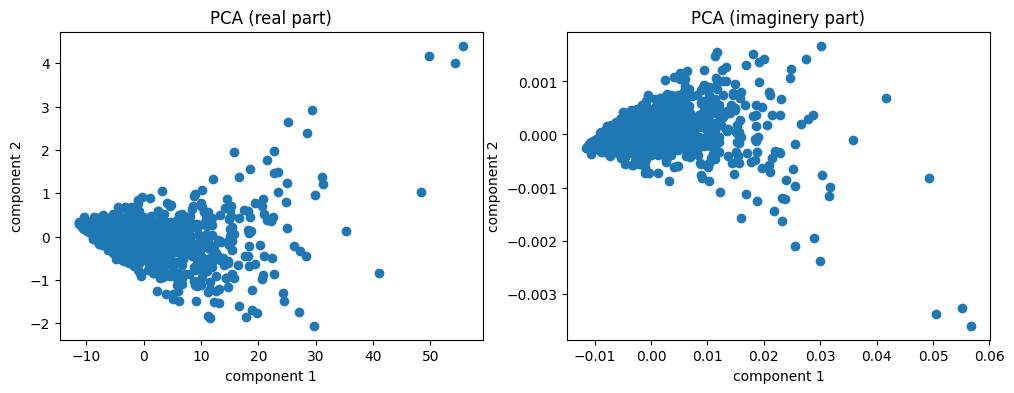

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter((joint_pcs[:,0]).real,(joint_pcs[:,1]).real)
axs[1].scatter((joint_pcs[:,0]).imag,(joint_pcs[:,1]).imag)

axs[0].set_title('PCA (real part)')
axs[1].set_title('PCA (imaginery part)')

axs[0].set_xlabel('component 1')
axs[0].set_ylabel('component 2')
axs[1].set_xlabel('component 1')
axs[1].set_ylabel('component 2')

PC1

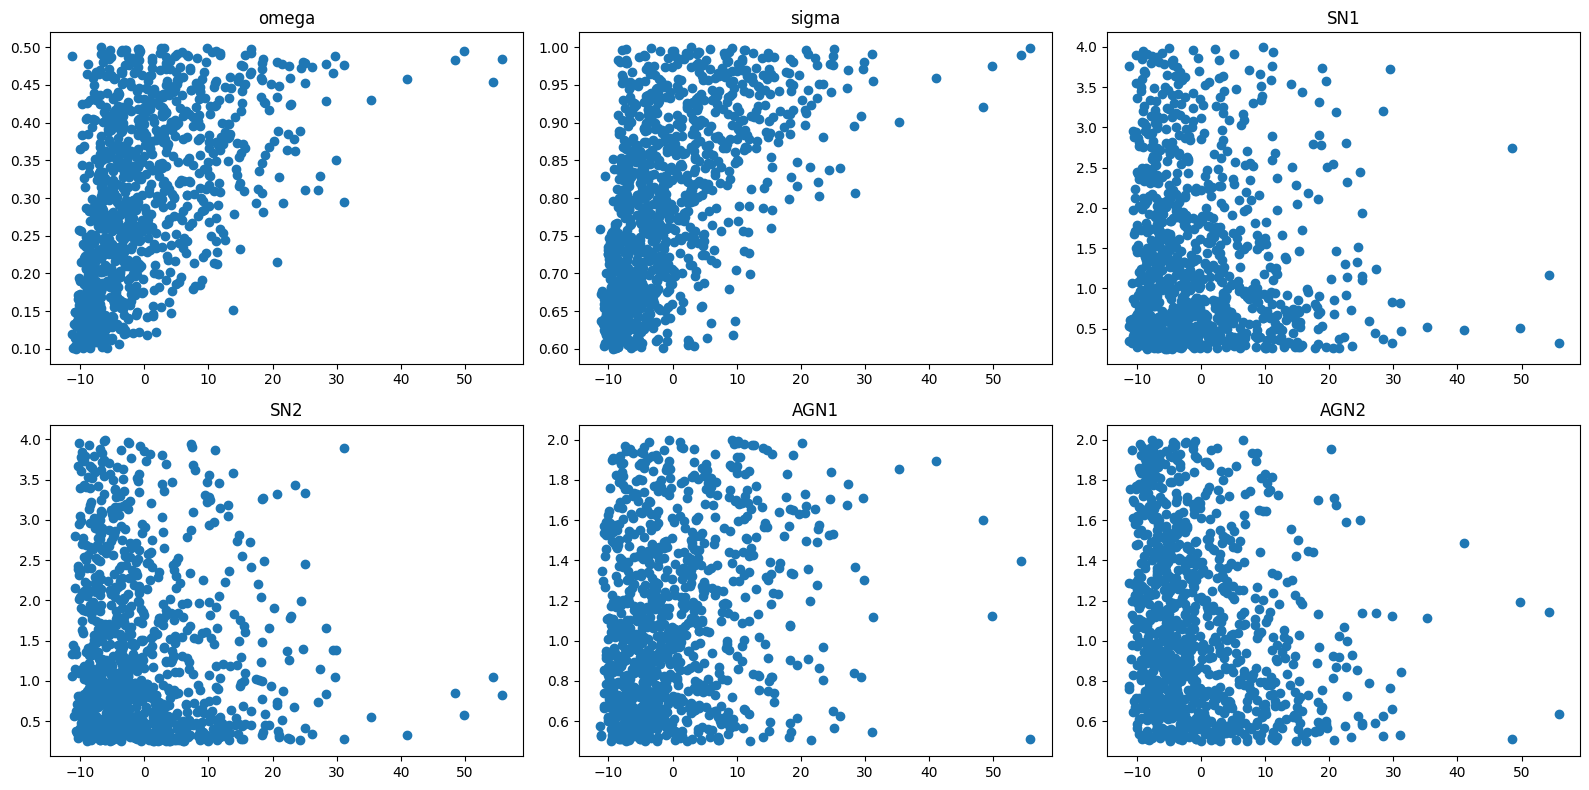

In [18]:
# pc1 real part
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs[:,0]).real,params['sigma'])
axs[0,2].scatter((joint_pcs[:,0]).real,params['SN1'])
axs[1,0].scatter((joint_pcs[:,0]).real,params['SN2'])
axs[1,1].scatter((joint_pcs[:,0]).real,params['AGN1'])
axs[1,2].scatter((joint_pcs[:,0]).real,params['AGN2'])


fig.tight_layout()
fig.show()

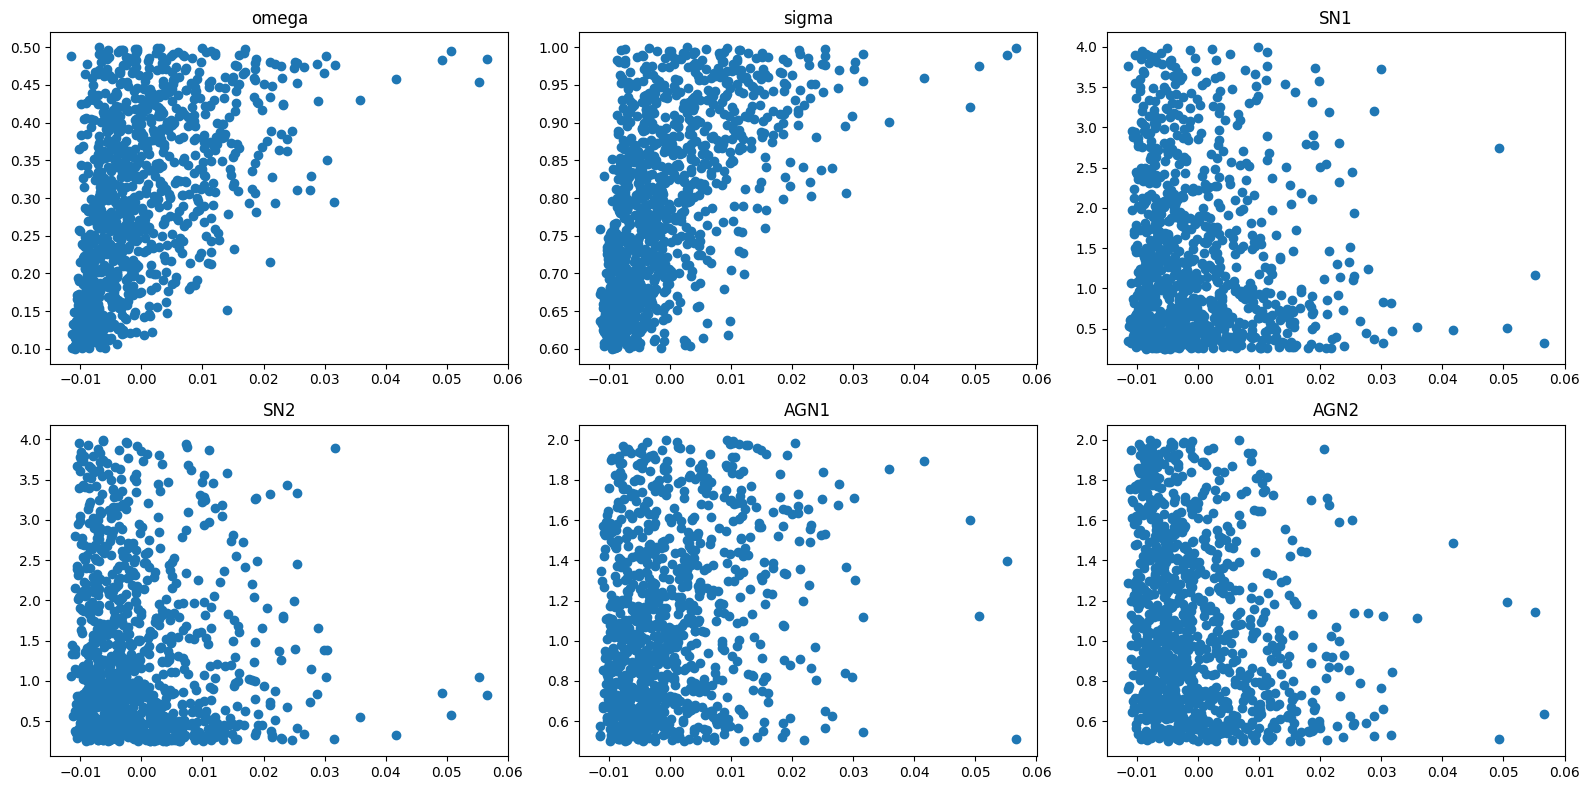

In [19]:
# pc1 imag part
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs[:,0]).imag,params['omega'])
axs[0,1].scatter((joint_pcs[:,0]).imag,params['sigma'])
axs[0,2].scatter((joint_pcs[:,0]).imag,params['SN1'])
axs[1,0].scatter((joint_pcs[:,0]).imag,params['SN2'])
axs[1,1].scatter((joint_pcs[:,0]).imag,params['AGN1'])
axs[1,2].scatter((joint_pcs[:,0]).imag,params['AGN2'])


fig.tight_layout()
fig.show()

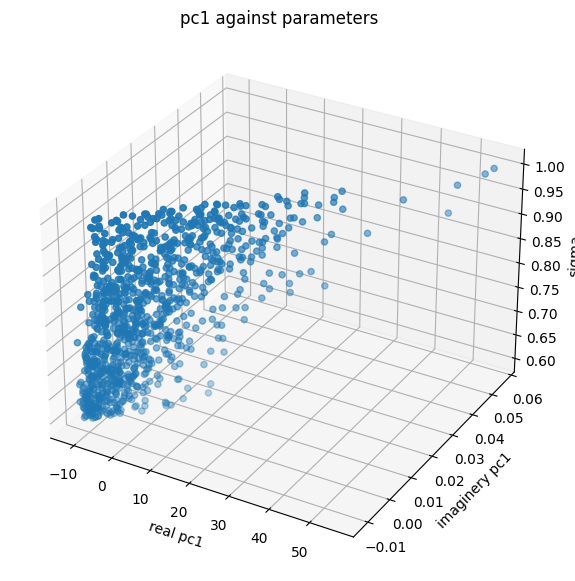

In [20]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D((joint_pcs[:,0]).real, (joint_pcs[:,0]).imag, params['sigma'])
ax.set_xlabel('real pc1')
ax.set_ylabel('imaginery pc1')
ax.set_zlabel('sigma')
plt.title("pc1 against parameters")
plt.show()

In [60]:
s11_pos = S11_shape
s00_pos = S11_shape + S00_shape
c00_pos = S11_shape + S00_shape + C00_shape
s01_pos = S11_shape + S00_shape + C00_shape + S01_shape
c01_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape
s10_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape
c10_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape
cphase_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape + Cphase_shape
cphase_inv_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape + Cphase_shape + Cphase_inv_shape
l_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape + Cphase_shape + Cphase_inv_shape + L_shape

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


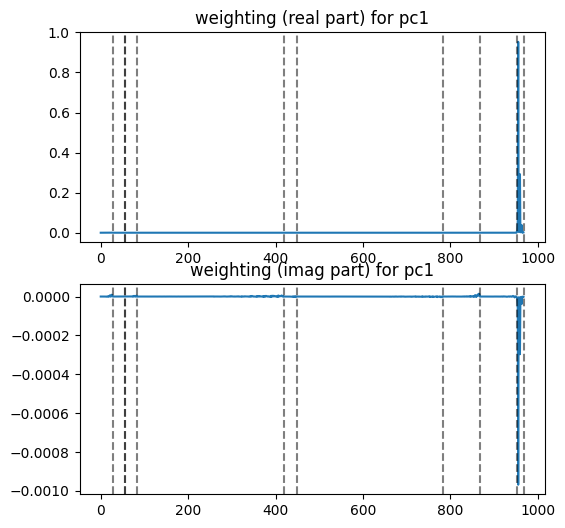

In [61]:
# weight for pc1
joint_weight1 = PCA_weight(wph_joint_coeffs_1000, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(joint_weight1.real)
axs[1].plot(joint_weight1.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(l_pos, linestyle='dashed', color='black', alpha=0.5)


### if we remove L

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


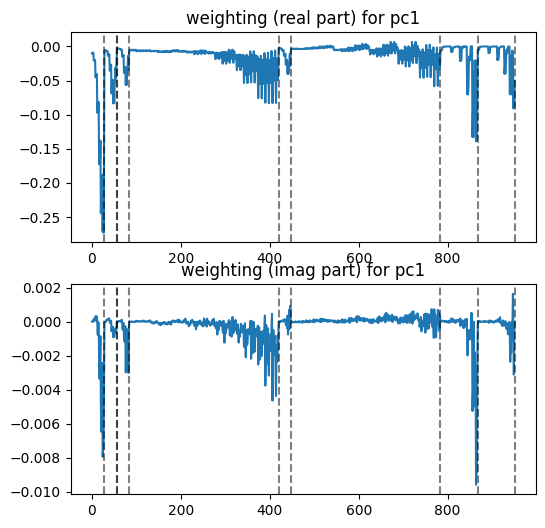

In [62]:
wph_joint_coeffs_900 = wph_joint_coeffs_1000.iloc[:,:cphase_inv_pos]

joint_weight0 = PCA_weight(wph_joint_coeffs_900, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(joint_weight0.real)
axs[1].plot(joint_weight0.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos, linestyle='dashed', color='black', alpha=0.5)
  #axs[i].axvline(l_pos, linestyle='dashed', color='black', alpha=0.5)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


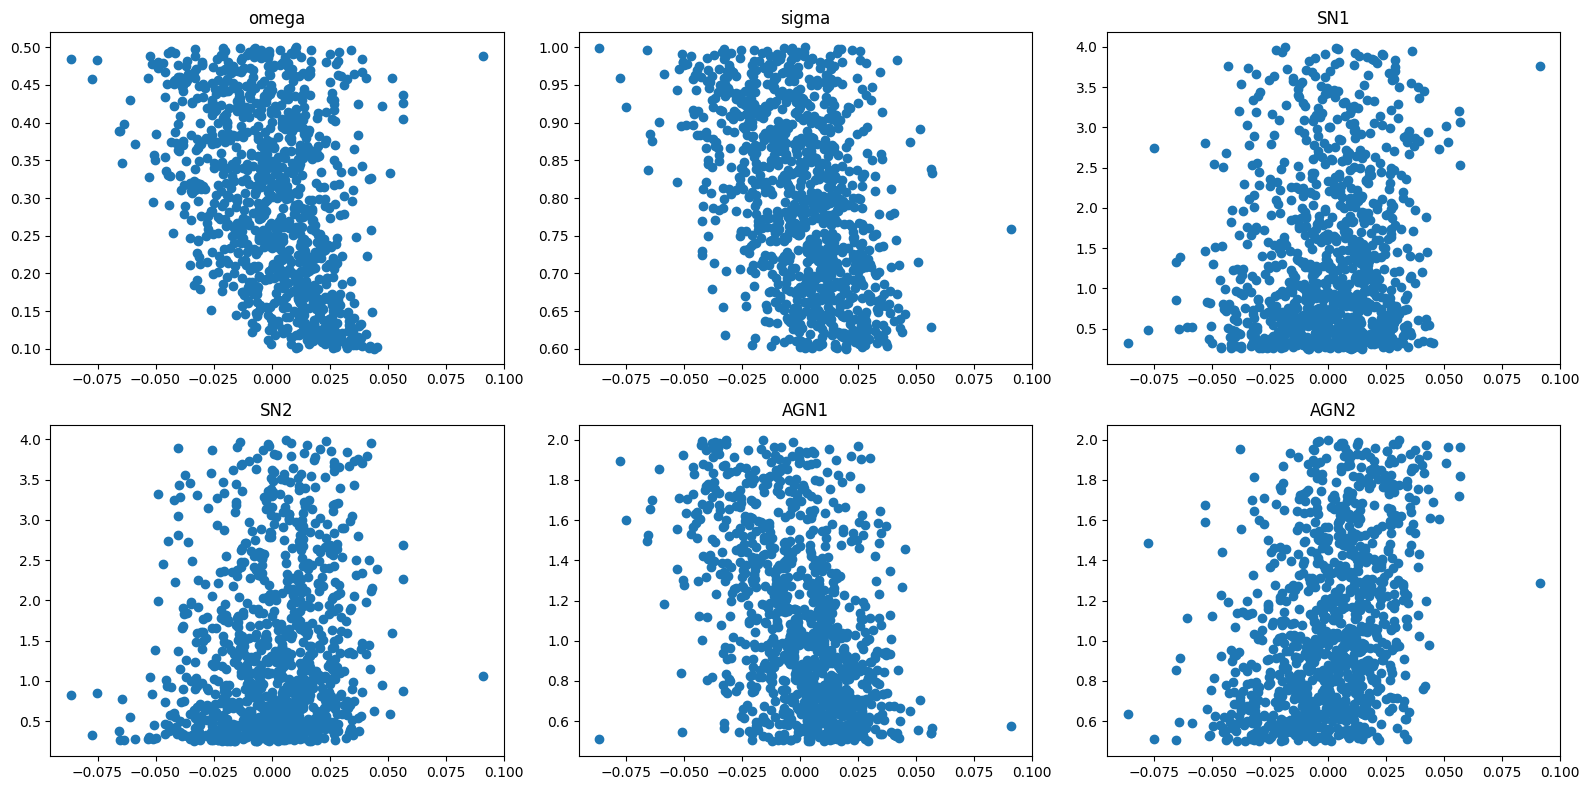

In [63]:
# pc1 real part
joint_pcs_900 = PCA(wph_joint_coeffs_900,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs_900[:,0]).real,params['sigma'])
axs[0,2].scatter((joint_pcs_900[:,0]).real,params['SN1'])
axs[1,0].scatter((joint_pcs_900[:,0]).real,params['SN2'])
axs[1,1].scatter((joint_pcs_900[:,0]).real,params['AGN1'])
axs[1,2].scatter((joint_pcs_900[:,0]).real,params['AGN2'])


fig.tight_layout()
fig.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


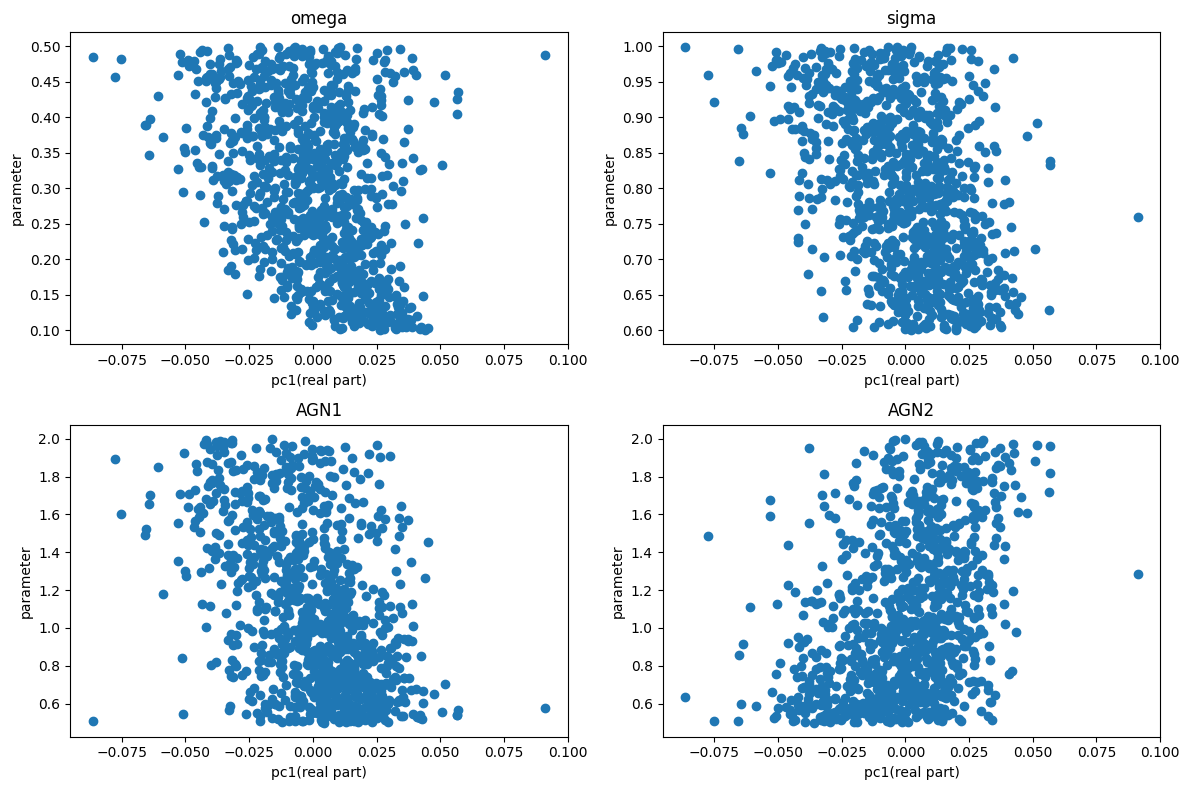

In [64]:
# pc1 real part
joint_pcs_900 = PCA(wph_joint_coeffs_900,2)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[1,0].set_title('AGN1')
axs[1,1].set_title('AGN2')

axs[0,0].scatter((joint_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs_900[:,0]).real,params['sigma'])
axs[1,0].scatter((joint_pcs_900[:,0]).real,params['AGN1'])
axs[1,1].scatter((joint_pcs_900[:,0]).real,params['AGN2'])

for i in range(0,2):
  for j in range(0,2):
    axs[i,j].set_xlabel('pc1(real part)')
    axs[i,j].set_ylabel('parameter')

fig.tight_layout()
fig.show()

### if we also remove s11

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


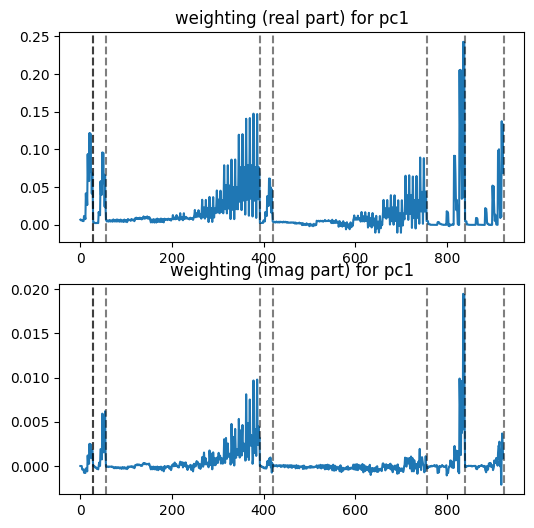

In [69]:
wph_joint_coeffs_900 = wph_joint_coeffs_1000.iloc[:,s11_pos:cphase_inv_pos]

joint_weight0 = PCA_weight(wph_joint_coeffs_900, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(joint_weight0.real)
axs[1].plot(joint_weight0.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  #axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


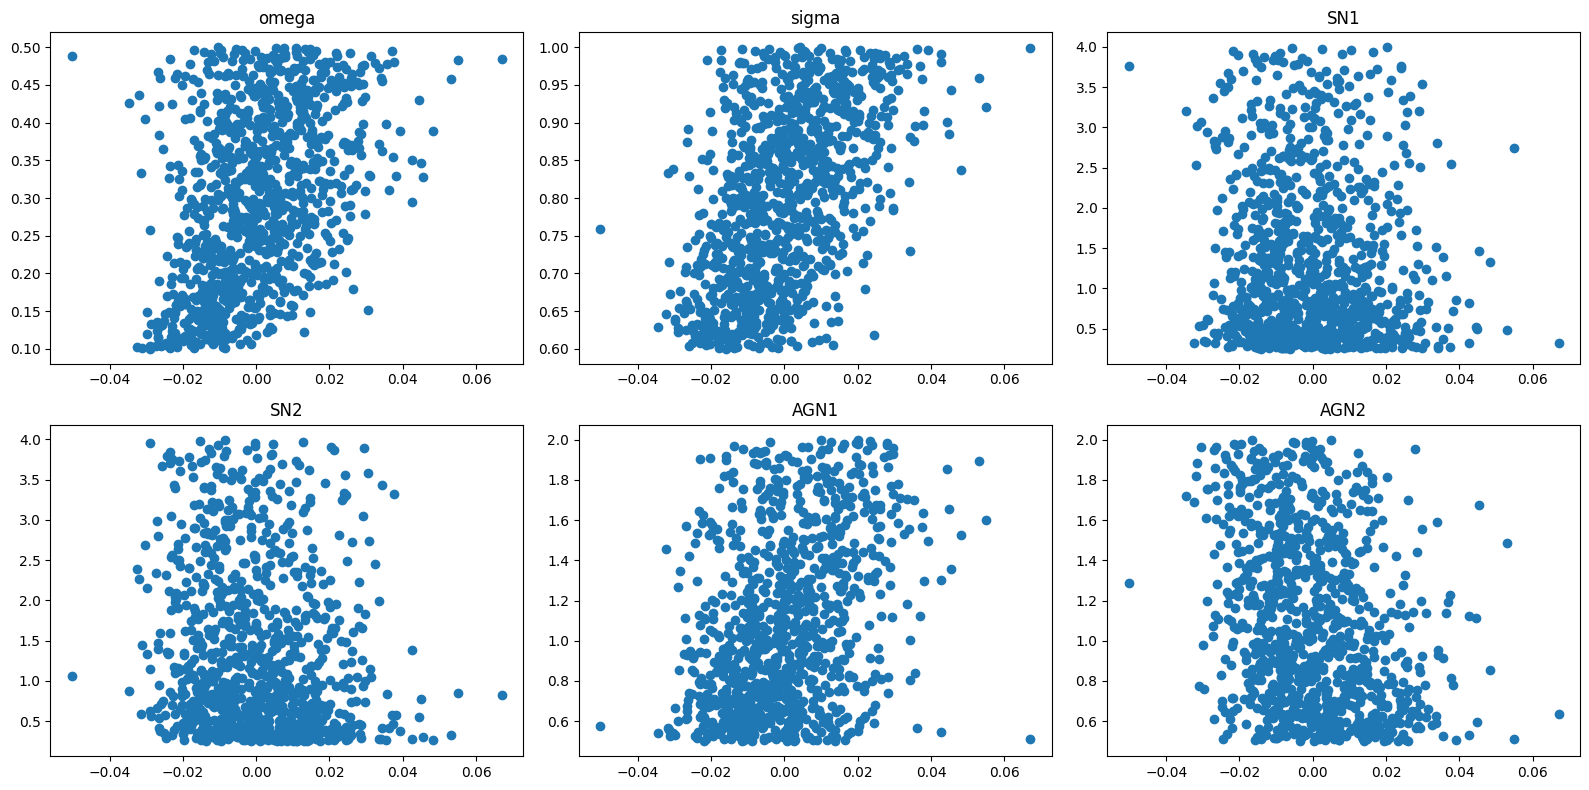

In [70]:
# pc1 real part
joint_pcs_900 = PCA(wph_joint_coeffs_900,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs_900[:,0]).real,params['sigma'])
axs[0,2].scatter((joint_pcs_900[:,0]).real,params['SN1'])
axs[1,0].scatter((joint_pcs_900[:,0]).real,params['SN2'])
axs[1,1].scatter((joint_pcs_900[:,0]).real,params['AGN1'])
axs[1,2].scatter((joint_pcs_900[:,0]).real,params['AGN2'])

fig.tight_layout()
fig.show()

### use normalisation = 'auto' instead of 'None'

In [13]:
num = 1000
nbody_data = np.log(nbody_file)
mgas_data = np.log(mgas_file)
wph_norm_coeffs_1000 = np.zeros((num,968), dtype='complex')

for i in range(0,num):
  if i%50==0: print(i)
  joint_coeff = wph_op([nbody_data[(i*15):(i*15+15)], mgas_data[(i*15):(i*15+15)]], cross=True, pbc=True, norm='auto')
  wph_norm_coeffs_1000[i] = joint_coeff.mean(axis=0).cpu()


0


/usr/local/lib/python3.10/dist-packages/pywph/wph_operator.py:774: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 -= mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [14]:
wph_norm_coeffs_1000 = pd.DataFrame(wph_norm_coeffs_1000)

In [76]:
wph_norm_coeffs_1000

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
0,0.560034+0.004824j,0.570893+0.005788j,0.556626+0.002248j,0.560341-0.001459j,0.785648+0.005779j,0.787587+0.002288j,0.783978+0.003040j,0.780002-0.000260j,0.911893+0.001891j,0.913616-0.002671j,...,1.000000+0.000000j,1.000000+0.000000j,1.000000+0.000000j,1.000000+0.000000j,1.000000+0.000000j,1.0000000+0.0000000j,1.000000+0.000000j,1.000000+0.000000j,1.0000000+0.0000000j,1.0000000+0.0000000j
1,0.328203+0.000075j,0.298392-0.003933j,0.328166-0.002066j,0.332508+0.002793j,0.499879-0.000970j,0.434595-0.008130j,0.500914-0.002925j,0.505673+0.001959j,0.677838-0.001997j,0.592907-0.011292j,...,5.385780+0.000000j,11.803721+0.000000j,4.265368+0.000000j,3.143149+0.000000j,13.676794+0.000000j,40.486721+0.000000j,11.745716+0.000000j,6.438919+0.000000j,67.679398+0.000000j,309.015594+0.000000j
2,0.365535-0.003923j,0.350101-0.001376j,0.368859-0.002266j,0.365114+0.001119j,0.345838-0.008093j,0.333382-0.007358j,0.343934-0.008859j,0.351580+0.000566j,0.396589+0.000359j,0.372066-0.010701j,...,13.633224+0.000000j,59.786610+0.000000j,5.964615+0.000000j,3.982679+0.000000j,25.398510+0.000000j,106.040947+0.000000j,15.888882+0.000000j,8.178077+0.000000j,129.606842+0.000000j,1004.86261+0.00000j
3,0.640852-0.001012j,0.605308-0.003608j,0.623227-0.003806j,0.633100-0.001859j,0.837898-0.003090j,0.749474-0.005395j,0.804712-0.007835j,0.797965-0.000766j,1.069993-0.005211j,0.924384-0.002666j,...,7.889258+0.000000j,24.570147+0.000000j,4.704730+0.000000j,3.401770+0.000000j,15.410280+0.000000j,48.110424+0.000000j,12.150311+0.000000j,6.767051+0.000000j,66.262535+0.000000j,277.889465+0.000000j
4,0.518362+0.004132j,0.508412+0.005797j,0.512000+0.000815j,0.537579-0.000416j,0.605043+0.006663j,0.590566+0.007009j,0.598080+0.002542j,0.643026-0.002622j,0.764327+0.005537j,0.739597+0.001007j,...,10.704706+0.000000j,31.197203+0.000000j,5.305156+0.000000j,3.490973+0.000000j,22.138416+0.000000j,83.106094+0.000000j,10.250371+0.000000j,5.473706+0.000000j,74.068298+0.000000j,474.507111+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.314707+0.000569j,0.281776-0.000596j,0.308878+0.000457j,0.296833+0.002081j,0.501087+0.000289j,0.422989-0.004362j,0.493117-0.002495j,0.451016+0.001926j,0.694661-0.002379j,0.579249-0.009624j,...,6.322753+0.000000j,13.947724+0.000000j,5.072449+0.000000j,3.555828+0.000000j,17.172016+0.000000j,49.449051+0.000000j,17.081717+0.000000j,8.812849+0.000000j,122.084953+0.000000j,704.773926+0.000000j
996,0.452936-0.001242j,0.438237-0.004384j,0.444179-0.007820j,0.452996+0.000135j,0.636643-0.005516j,0.593427-0.006615j,0.612170-0.015678j,0.615780+0.003132j,0.852463-0.007689j,0.777292-0.008270j,...,4.859373+0.000000j,9.671496+0.000000j,3.625134+0.000000j,2.843589+0.000000j,9.320743+0.000000j,20.512959+0.000000j,9.011336+0.000000j,5.582103+0.000000j,41.717243+0.000000j,160.083221+0.000000j
997,0.648155+0.000063j,0.634972-0.005917j,0.638556-0.001940j,0.632013+0.001655j,0.737106+0.001706j,0.711045-0.007978j,0.715935-0.001752j,0.701237+0.003763j,0.887293+0.005575j,0.836026-0.004217j,...,9.727214+0.000000j,36.774357+0.000000j,4.985509+0.000000j,3.546657+0.000000j,18.948145+0.000000j,75.731529+0.000000j,11.470080+0.000000j,6.500899+0.000000j,64.991364+0.000000j,314.646912+0.000000j
998,0.905330-0.002052j,0.913139-0.000357j,0.897957+0.002862j,0.924874+0.002998j,1.057265-0.003258j,1.045857+0.000458j,1.038492+0.007487j,1.063116+0.003568j,1.206421-0.003472j,1.168961-0.004382j,...,5.127234+0.000000j,11.797662+0.000000j,3.095616+0.000000j,2.428165+0.000000j,8.917631+0.000000j,25.884182+0.000000j,8.010965+0.000000j,4.661931+0.000000j,43.143845+0.000000j,206.379608+0.000000j


In [19]:
PCA_explained_variance_ratio(wph_norm_coeffs_1000,2)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


array([0.99734597, 0.00190311])

In [20]:
norm_pcs = PCA(wph_norm_coeffs_1000,2)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


In [73]:
norm_pcs.shape

(1000, 2)

Text(0, 0.5, 'component 2')

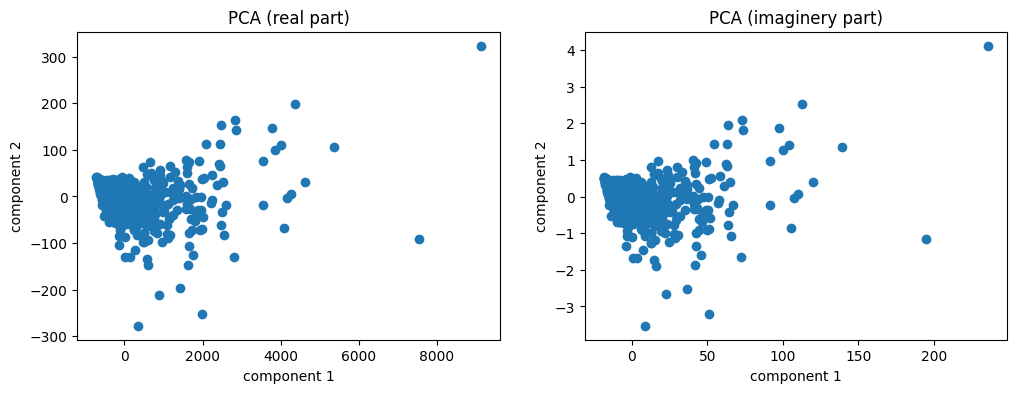

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter((norm_pcs[:,0]).real,(norm_pcs[:,1]).real)
axs[1].scatter((norm_pcs[:,0]).imag,(norm_pcs[:,1]).imag)

axs[0].set_title('PCA (real part)')
axs[1].set_title('PCA (imaginery part)')

axs[0].set_xlabel('component 1')
axs[0].set_ylabel('component 2')
axs[1].set_xlabel('component 1')
axs[1].set_ylabel('component 2')

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


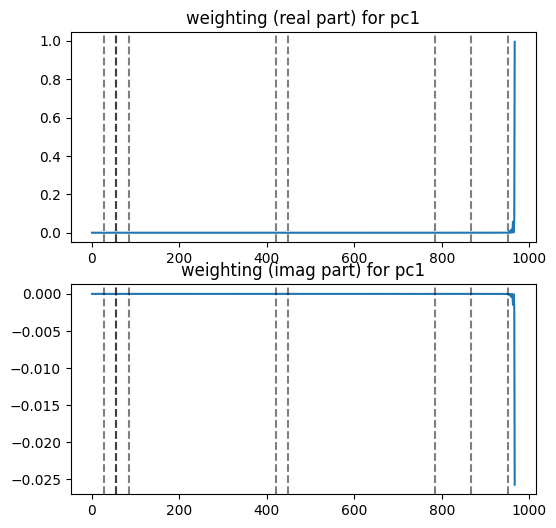

In [28]:
# weighting
norm_weight = PCA_weight(wph_norm_coeffs_1000, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(norm_weight.real)
axs[1].plot(norm_weight.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos, linestyle='dashed', color='black', alpha=0.5)
  #axs[i].axvline(l_pos, linestyle='dashed', color='black', alpha=0.5)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


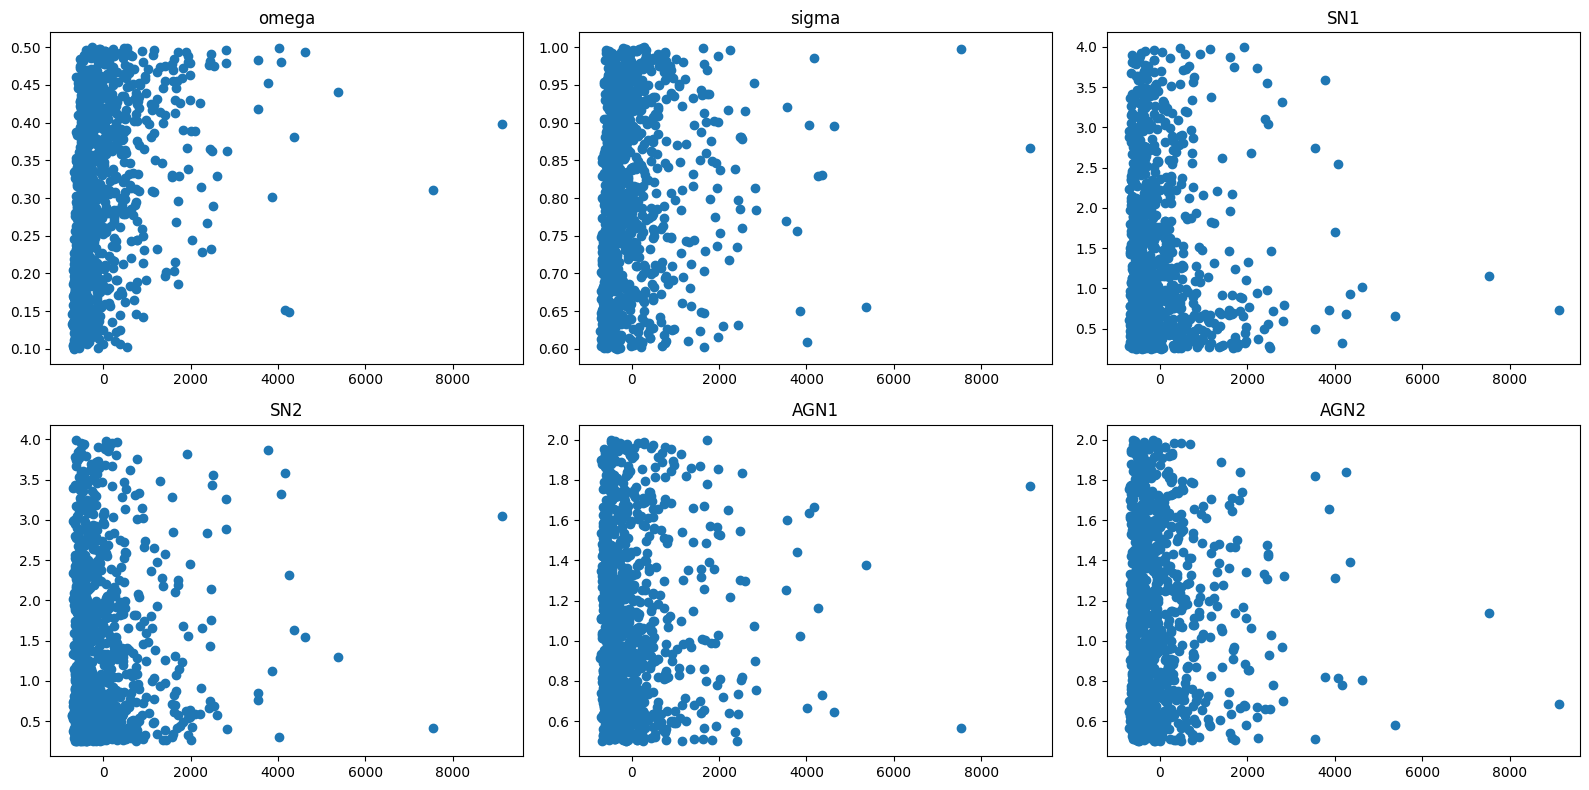

In [29]:
# pc1 real part
norm_pcs = PCA(wph_norm_coeffs_1000,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((norm_pcs[:,0]).real,params['omega'])
axs[0,1].scatter((norm_pcs[:,0]).real,params['sigma'])
axs[0,2].scatter((norm_pcs[:,0]).real,params['SN1'])
axs[1,0].scatter((norm_pcs[:,0]).real,params['SN2'])
axs[1,1].scatter((norm_pcs[:,0]).real,params['AGN1'])
axs[1,2].scatter((norm_pcs[:,0]).real,params['AGN2'])


fig.tight_layout()
fig.show()

remove L and s11

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


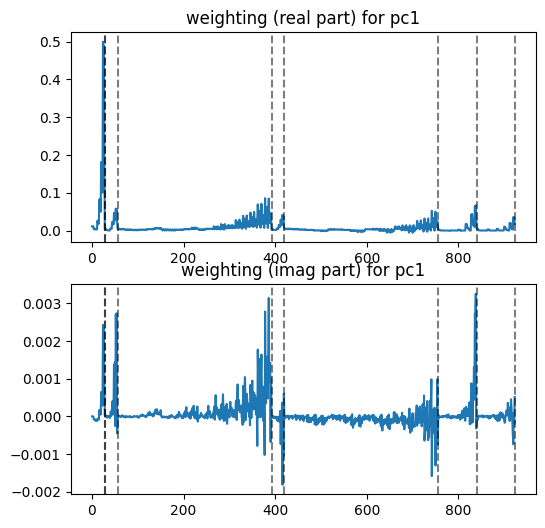

In [105]:
wph_norm_coeffs_900 = wph_norm_coeffs_1000.iloc[:,s11_pos:cphase_inv_pos]

norm_weight0 = PCA_weight(wph_norm_coeffs_900, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(norm_weight0.real)
axs[1].plot(norm_weight0.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  #axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:906: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


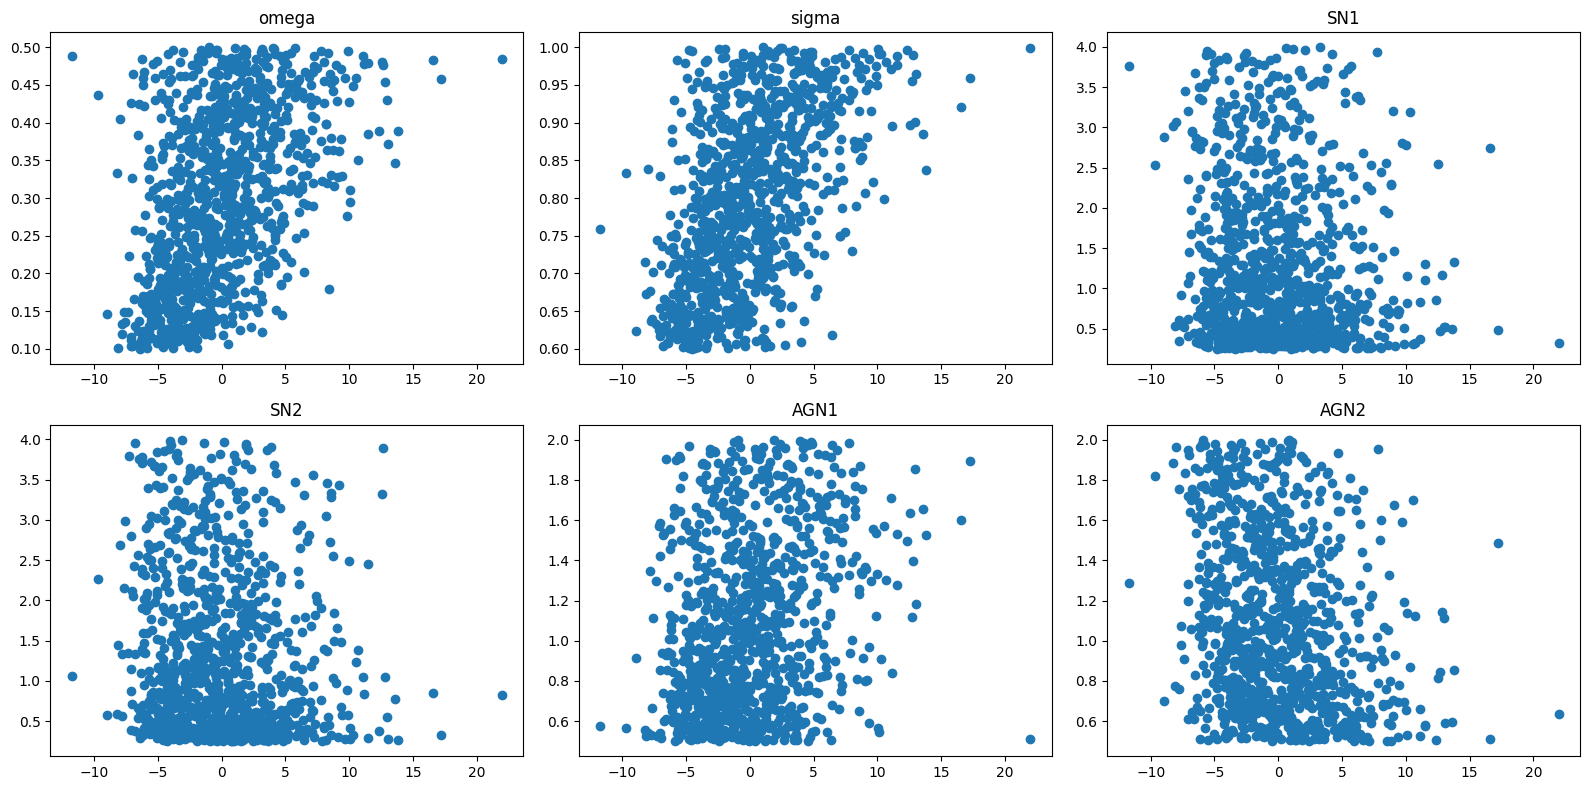

In [106]:
# pc1 real part
norm_pcs_900 = PCA(wph_norm_coeffs_900,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((norm_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((norm_pcs_900[:,0]).real,params['sigma'])
axs[0,2].scatter((norm_pcs_900[:,0]).real,params['SN1'])
axs[1,0].scatter((norm_pcs_900[:,0]).real,params['SN2'])
axs[1,1].scatter((norm_pcs_900[:,0]).real,params['AGN1'])
axs[1,2].scatter((norm_pcs_900[:,0]).real,params['AGN2'])

fig.tight_layout()
fig.show()